In [27]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
import numpy as np
from sklearn.metrics import mean_absolute_error

In [28]:
import os
path = os.getcwd()
parent_path = os.path.abspath(os.path.join(path, os.pardir))


In [29]:
until_2021 = pd.read_csv(os.path.abspath(parent_path + '/data/GEDEvent_v22_1.csv'))
candidates = pd.read_csv(os.path.abspath(parent_path + '/data/candidates_120523.csv'))

ucdp_og = pd.concat([until_2021, candidates], ignore_index=True)
ucdp_og.head()

/var/folders/r9/gyc839012fz27dyc44xgpv9r0000gn/T/ipykernel_33088/3843197302.py:1: DtypeWarning:

Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.



,id,relid,year,active_year,code_status,type_of_violence,conflict_dset_id,conflict_new_id,conflict_name,dyad_dset_id,...,date_end,deaths_a,deaths_b,deaths_civilians,deaths_unknown,best,high,low,gwnoa,gwnob
0,244657,IRQ-2017-1-524-322,2017,1,Clear,1,259,259,Iraq: Government,524,...,2017-07-31 00:00:00.000,0,4,0,2,6,6,6,645,NaN
1,412700,IRQ-2021-1-524-145,2021,1,Clear,1,259,259,Iraq: Government,524,...,2021-08-26 00:00:00.000,13,1,141,28,183,184,171,645,NaN
2,413023,IRQ-2021-1-524-143,2021,1,Clear,1,259,259,Iraq: Government,524,...,2021-08-28 00:00:00.000,0,2,0,0,2,3,0,645,NaN
3,412909,IRQ-2021-1-524-144,2021,1,Clear,1,259,259,Iraq: Government,524,...,2021-08-29 00:00:00.000,0,0,10,0,10,10,9,645,NaN
4,132140,AFG-1989-1-411-2,1989,1,Clear,1,333,333,Afghanistan: Government,724,...,1989-01-13 00:00:00.000,6,0,0,0,6,6,6,700,NaN


In [30]:
ucdp = ucdp_og.copy()

In [31]:
#ValueError: time data '2017-07-31 00:00:00.000' does not match format 'ISO8601' (match)

ucdp.date_start = pd.to_datetime(ucdp.date_start) #, format='ISO8601')
ucdp.date_start[1]


Timestamp('2021-08-26 00:00:00')

In [32]:
ucdp_nigeria = ucdp[ucdp['country']=='Nigeria']

In [33]:
ucdp_nigeria = ucdp_nigeria.set_index('date_start')

print(ucdp_nigeria.shape)
ucdp_nigeria.head()

(6513, 48)


,id,relid,year,active_year,code_status,type_of_violence,conflict_dset_id,conflict_new_id,conflict_name,dyad_dset_id,...,date_end,deaths_a,deaths_b,deaths_civilians,deaths_unknown,best,high,low,gwnoa,gwnob
date_start,,,,,,,,,,,,,,,,,,,,,
2009-06-09,15960,NIG-2009-1-793-1,2009,1,Clear,1,297,297,Nigeria: Government,640,...,2009-06-09 00:00:00.000,0,0,0,0,0,14,0,475.0,NaN
2009-07-26,15970,NIG-2009-1-793-4,2009,1,Clear,1,297,297,Nigeria: Government,640,...,2009-07-28 00:00:00.000,13,87,0,103,203,206,203,475.0,NaN
2009-07-26,15720,NIG-2009-1-793-5.2,2009,1,Clear,1,297,297,Nigeria: Government,640,...,2009-07-27 00:00:00.000,2,9,0,0,11,11,11,475.0,NaN
2009-07-26,15733,NIG-2009-1-793-2,2009,1,Clear,1,297,297,Nigeria: Government,640,...,2009-07-26 00:00:00.000,1,37,3,1,42,51,39,475.0,NaN
2009-07-26,17161,NIG-2009-1-793-5.1,2009,1,Clear,1,297,297,Nigeria: Government,640,...,2009-07-27 00:00:00.000,2,10,0,0,12,12,12,475.0,NaN


In [34]:
TARGET = "best"
ucdp_nigeria[[TARGET]].describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
best,6513.0,10.43,44.95,0.0,1.0,3.0,8.0,2478.0


In [35]:
ucdp_nigeria['best'].value_counts().value_counts()

1       56
2       18
5        7
3        5
4        5
10       4
12       4
53       2
14       2
83       2
11       2
9        2
7        2
6        2
29       1
8        1
16       1
18       1
23       1
24       1
27       1
28       1
1110     1
943      1
146      1
864      1
757      1
386      1
326      1
207      1
195      1
159      1
118      1
35       1
98       1
70       1
63       1
61       1
59       1
52       1
44       1
31       1
Name: best, dtype: int64

In [36]:
ucdp_nigeria_w = ucdp_nigeria.resample('W')[[TARGET]].sum()

ucdp_nigeria_w['date'] = ucdp_nigeria_w.index.date
print(ucdp_nigeria_w.shape)
print(ucdp_nigeria_w.index.min(), ucdp_nigeria_w.index.max())
print(ucdp_nigeria_w.head())
ucdp_nigeria_w.describe().round(2).T

(1697, 2)
1990-09-30 00:00:00 2023-04-02 00:00:00
            best        date
date_start                  
1990-09-30     9  1990-09-30
1990-10-07     0  1990-10-07
1990-10-14     0  1990-10-14
1990-10-21     0  1990-10-21
1990-10-28     0  1990-10-28


,count,mean,std,min,25%,50%,75%,max
best,1697.0,40.03,112.99,0.0,0.0,2.0,44.0,2525.0


1      100
2       24
4       21
5       16
3       14
8        9
7        8
6        6
12       6
11       4
9        3
10       2
16       2
14       1
13       1
50       1
15       1
17       1
18       1
20       1
28       1
32       1
777      1
Name: best, dtype: int64


<AxesSubplot:>

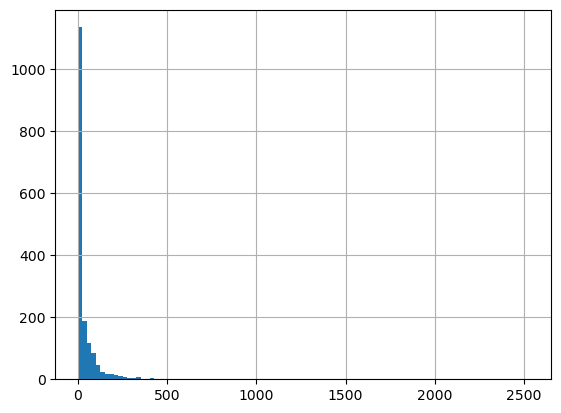

In [37]:
print(ucdp_nigeria_w['best'].value_counts().value_counts())
ucdp_nigeria_w['best'].hist(bins=100)


In [38]:
ucdp_nigeria_m = ucdp_nigeria.resample('M')[[TARGET]].sum()

ucdp_nigeria_m['date'] = ucdp_nigeria_m.index.date
print(ucdp_nigeria_m.index.min(), ucdp_nigeria_m.index.max())
print(ucdp_nigeria_m.shape)
print(ucdp_nigeria_m.head())
ucdp_nigeria_m.describe().round(2).T

1990-09-30 00:00:00 2023-03-31 00:00:00
(391, 2)
            best        date
date_start                  
1990-09-30     9  1990-09-30
1990-10-31    80  1990-10-31
1990-11-30     0  1990-11-30
1990-12-31     0  1990-12-31
1991-01-31     0  1991-01-31


,count,mean,std,min,25%,50%,75%,max
best,391.0,173.74,297.6,0.0,1.5,53.0,232.5,2525.0


1     154
2      31
4       6
3       6
6       3
5       2
84      1
14      1
7       1
Name: best, dtype: int64


<AxesSubplot:>

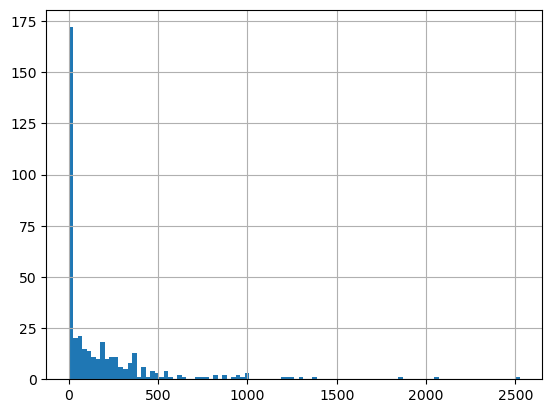

In [39]:
print(ucdp_nigeria_m['best'].value_counts().value_counts())
ucdp_nigeria_m['best'].hist(bins=100)

In [40]:
ix_start = int(np.random.uniform(0, ucdp_nigeria_m.shape[0] - 1000))
ix_end = ix_start + 1000
_nigeria = ucdp_nigeria_m.copy()#iloc[ix_start:ix_end]
px.line(_nigeria.reset_index(), x="date_start", y="best", title="Montly Deaths in Nigeria")

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': 'date_start=%{x}<br>best=%{y}<extra></extra>',
              'legendgroup': '',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': '',
              'orientation': 'v',
              'showlegend': False,
              'type': 'scatter',
              'x': array([datetime.datetime(1990, 9, 30, 0, 0),
                          datetime.datetime(1990, 10, 31, 0, 0),
                          datetime.datetime(1990, 11, 30, 0, 0), ...,
                          datetime.datetime(2023, 1, 31, 0, 0),
                          datetime.datetime(2023, 2, 28, 0, 0),
                          datetime.datetime(2023, 3, 31, 0, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([  9,  80,   0, ..., 237,  63, 648]),
              'yaxis': 'y'}],
    'layout': {'legend': {'tracegroupgap': 0},
               'template': '...',
               'title': {'text': 'Montly Deaths in Nigeria'},
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'date_start'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'best'}}}
})

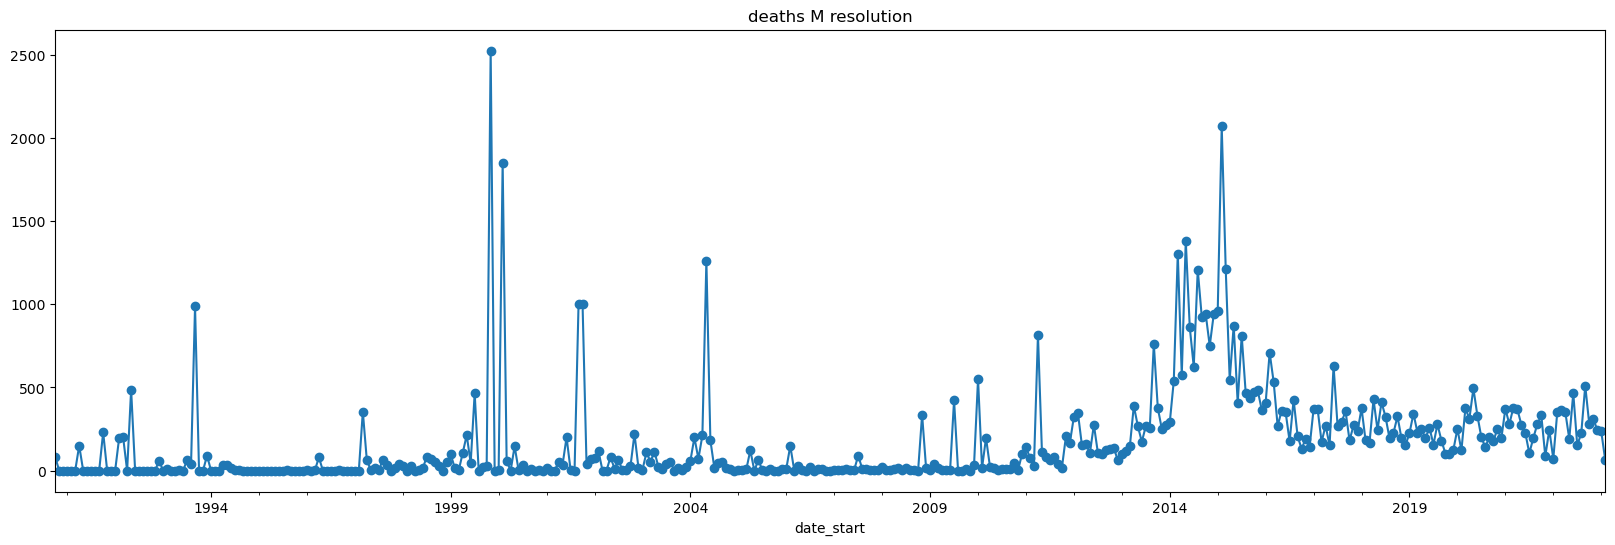

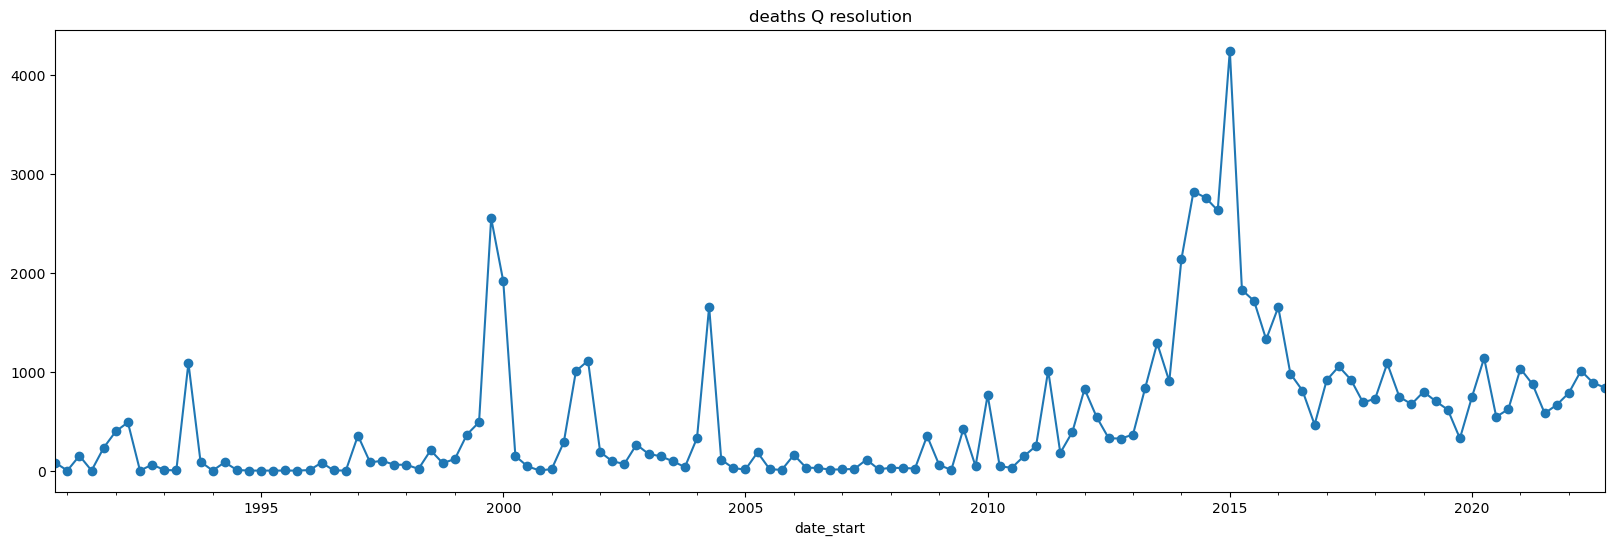

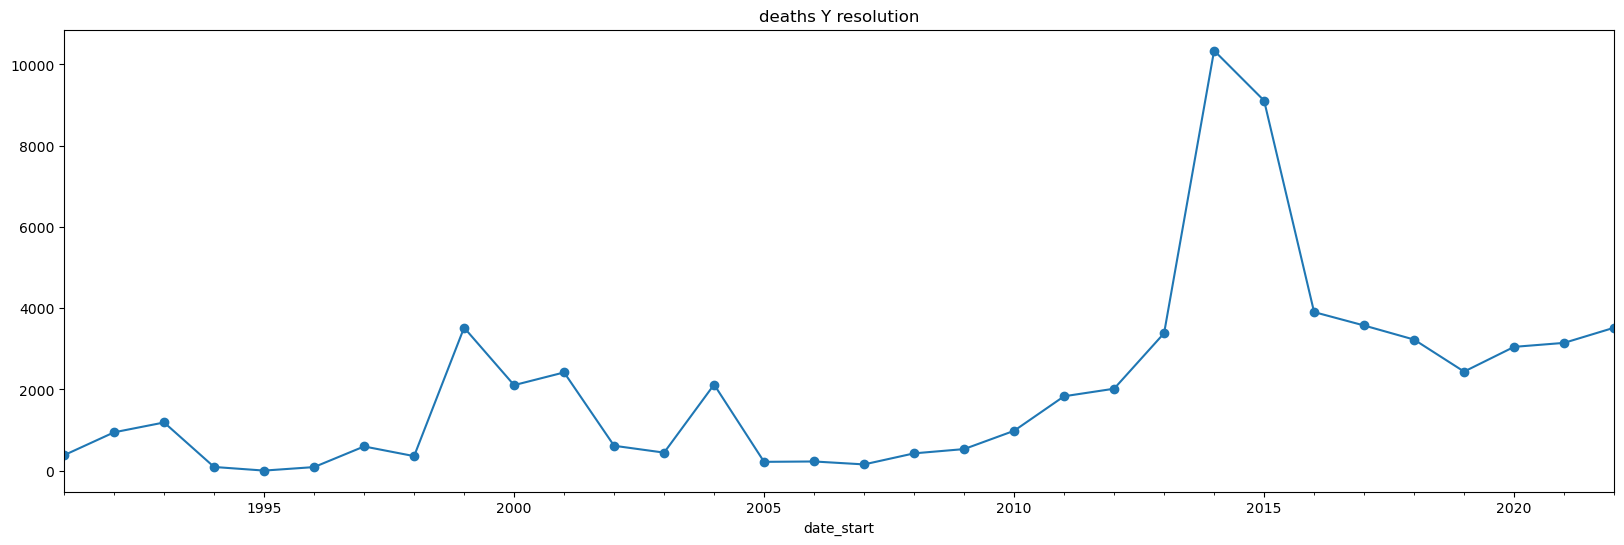

In [ ]:
for resolution in ['M', 'Q', 'Y']:
    fig, ax = plt.subplots(figsize=(20, 6))
    ucdp_nigeria_m['best'].resample(resolution).sum().iloc[1:-1].plot(ax=ax, marker='o')
    ax.set_title(f'deaths {resolution} resolution')

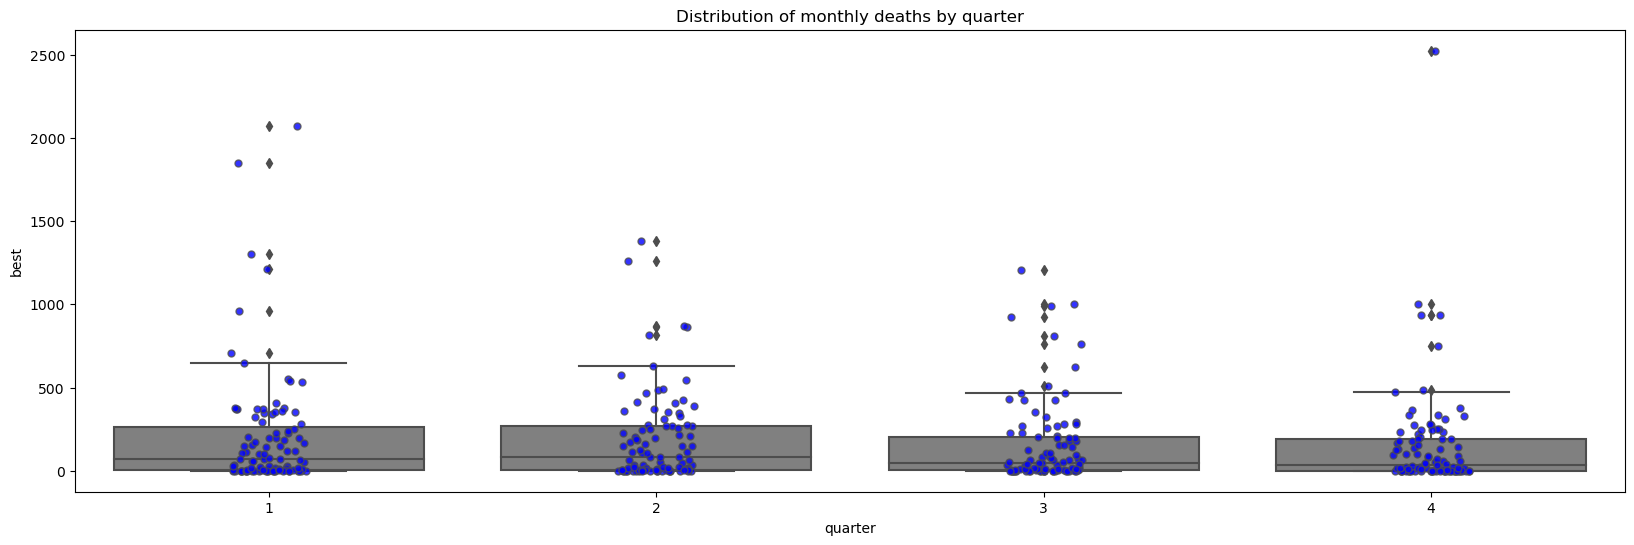

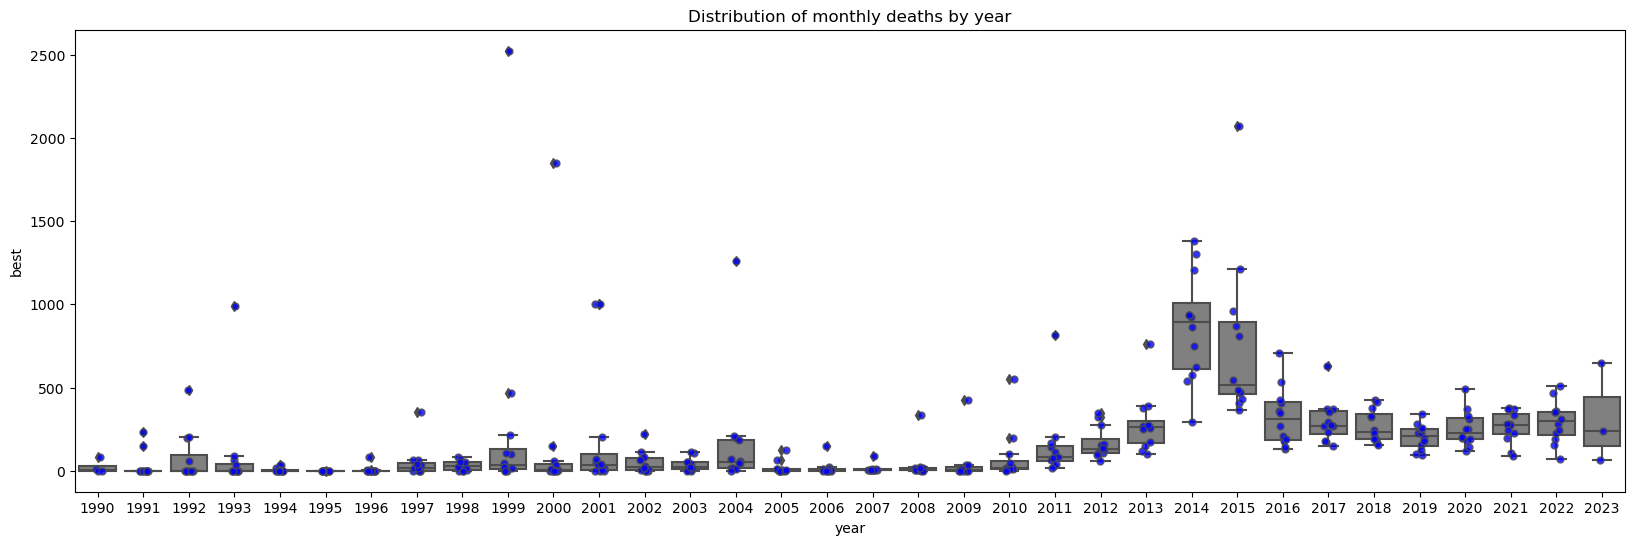

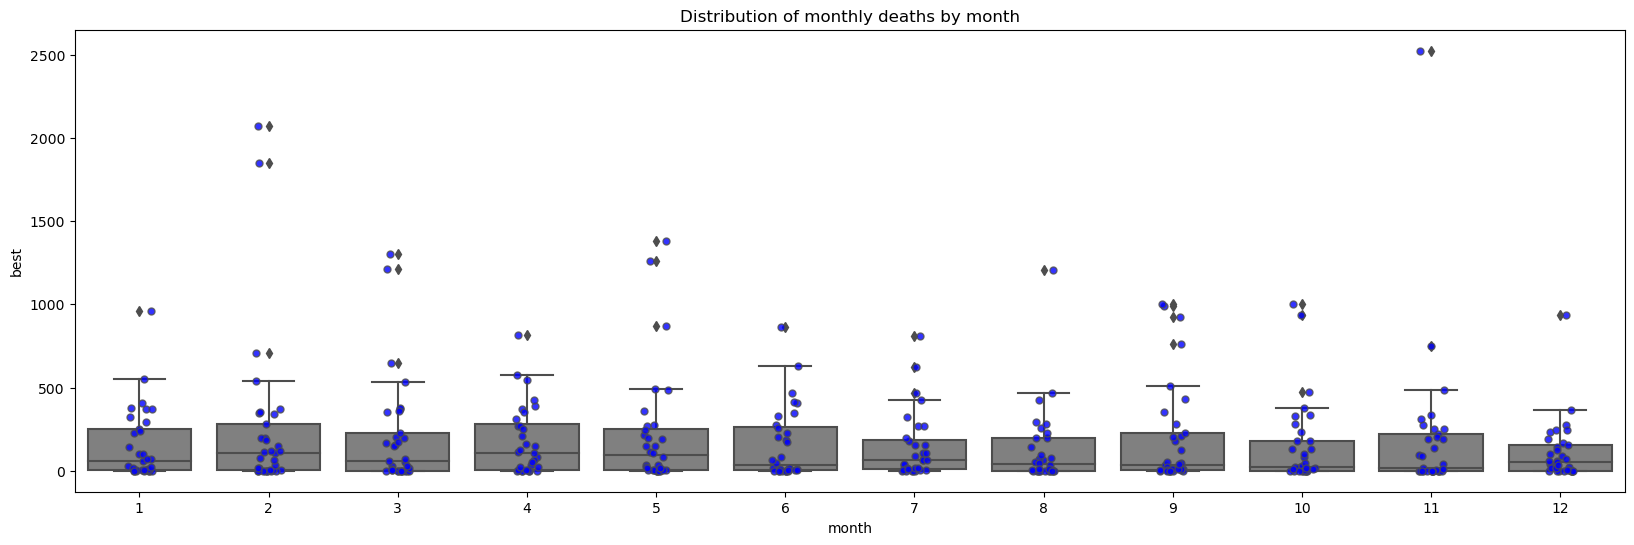

In [ ]:
ucdp_nigeria_m['quarter'] = ucdp_nigeria_m.index.quarter
ucdp_nigeria_m['year'] = ucdp_nigeria_m.index.year
ucdp_nigeria_m['month'] = ucdp_nigeria_m.index.month
#consumption_agg['hour'] = consumption_agg.index.hour
#consumption_agg['day_of_week'] = consumption_agg.index.dayofweek
#consumption_agg['day_of_week_hour'] = consumption_agg.apply(lambda x: f'{x["day_of_week"]}_{x["hour"]}', axis=1)

time_features = [
    'quarter',
    'year',
    'month',
    #'hour',
    #'day_of_week',
    #'day_of_week_hour',
]
for f_name in time_features:
    fig, ax = plt.subplots(figsize=(20, 6))
    sns.boxplot(x=f_name, y="best", data=ucdp_nigeria_m, ax=ax, color='grey')
    sns.stripplot(data=ucdp_nigeria_m, x=f_name, y='best', ax=ax, linewidth=1, color='b', alpha=.8)
    ax.set_title(f'Distribution of monthly deaths by {f_name}')


1.638


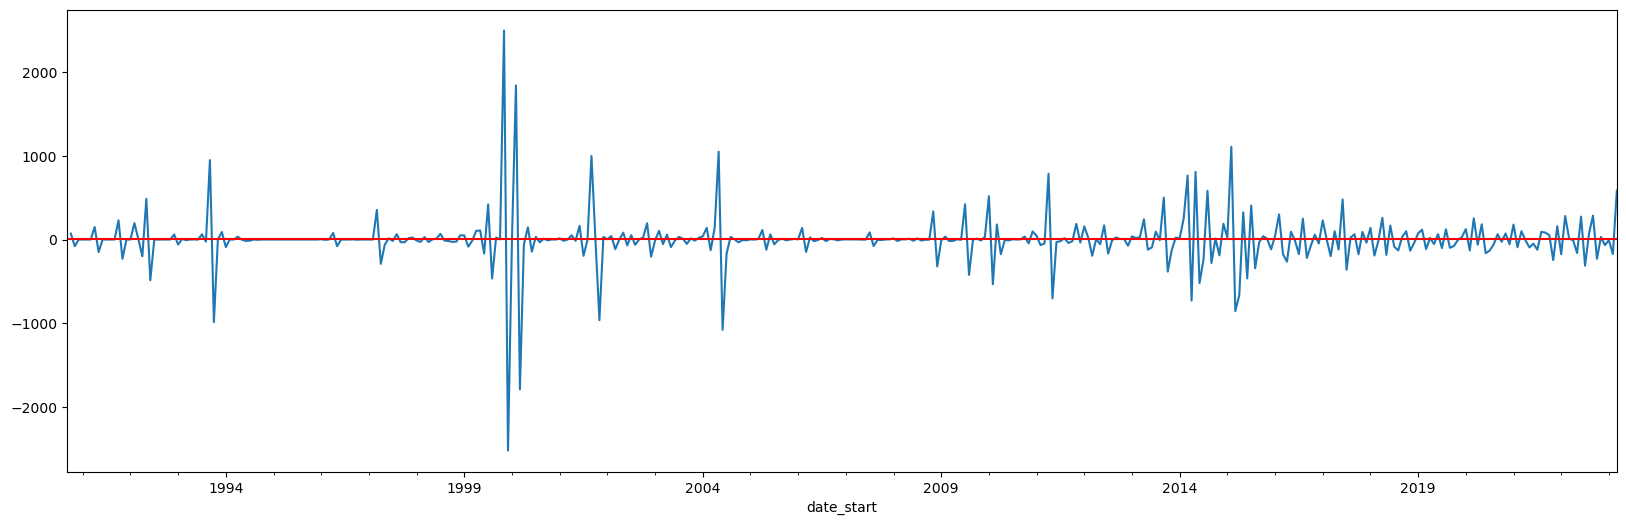

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
#Calculates the difference of a DataFrame element compared with another element in the DataFrame (default is element in previous row).
ax = ucdp_nigeria_m['best'].diff().plot(ax=ax)
print(ucdp_nigeria_m['best'].diff().mean().round(3))
ax.axhline(ucdp_nigeria_m['best'].diff().mean(), color='red')

## Modelling

In [ ]:
test_time = '2017-12-31'
#modelling_data = ucdp_nigeria_m[:test_time].copy()
modelling_data = ucdp_nigeria_m.copy()
train_df = modelling_data.loc[modelling_data.index < test_time]
#test_df = modelling_data.loc[test_time:]
test_df = modelling_data.loc[modelling_data.index >= test_time]

print(train_df.index.min(), train_df.index.max())
print(test_df.index.min(), test_df.index.max())

print(train_df.shape)
print(train_df.head())

print(test_df.shape)
print(test_df.head())

1990-09-30 00:00:00 2017-11-30 00:00:00
2017-12-31 00:00:00 2023-03-31 00:00:00
(327, 5)
            best        date  quarter  year  month
date_start                                        
1990-09-30     9  1990-09-30        3  1990      9
1990-10-31    80  1990-10-31        4  1990     10
1990-11-30     0  1990-11-30        4  1990     11
1990-12-31     0  1990-12-31        4  1990     12
1991-01-31     0  1991-01-31        1  1991      1
(64, 5)
            best        date  quarter  year  month
date_start                                        
2017-12-31   235  2017-12-31        4  2017     12
2018-01-31   375  2018-01-31        1  2018      1
2018-02-28   183  2018-02-28        1  2018      2
2018-03-31   168  2018-03-31        1  2018      3
2018-04-30   428  2018-04-30        2  2018      4


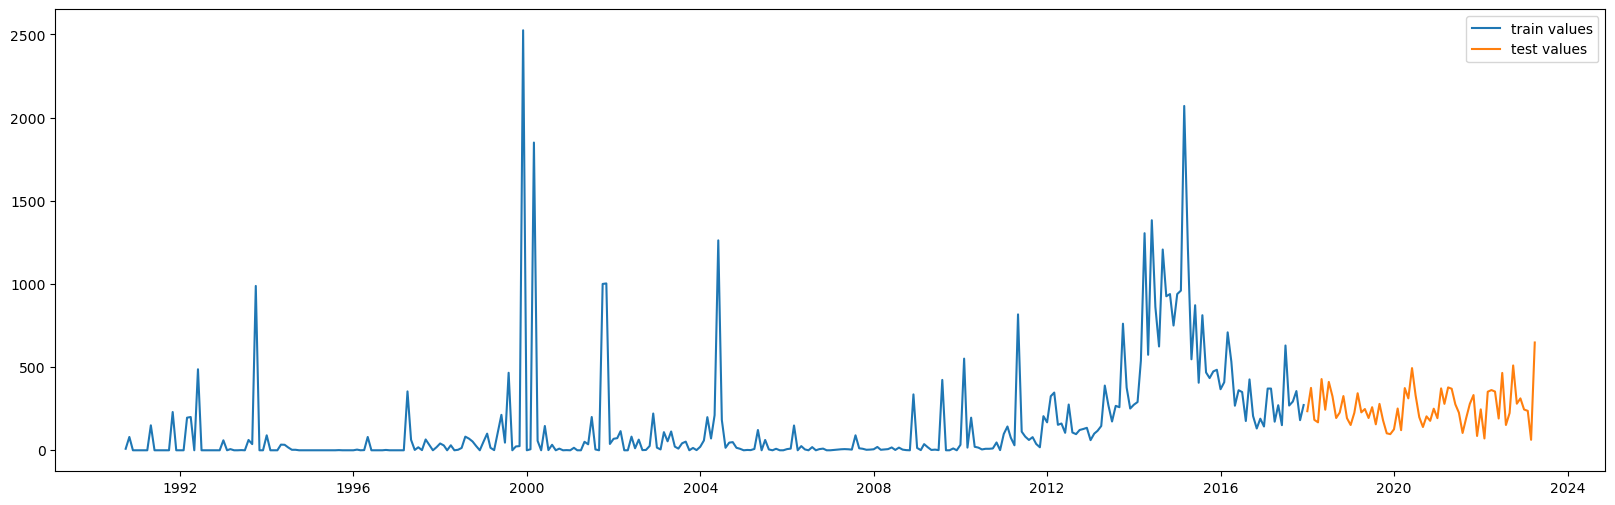

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(train_df['best'], label='train values') #.iloc[-300:]
ax.plot(test_df['best'], label='test values')
ax.legend()

### Naive: rolling mean

In [ ]:
losses = {}

In [ ]:
def plot_predictions(train_df, test_df, short_forecast, long_forecast=None, fitted=None, name=None, days_before=30):
    time_to_viz = pd.Timestamp(test_df.index.min()) - pd.Timedelta(days=days_before)
    real = pd.concat([train_df, test_df]).loc[time_to_viz:, 'best']
    fitted = fitted.loc[time_to_viz:] if fitted is not None else None
    fig, ax = plt.subplots(figsize=(20, 6))
    ax.plot(real, label='real values')
    if fitted is not None:
        ax.plot(fitted, label='fitted values')

    ax.plot(short_forecast, label='forecasted values (short)')
    if long_forecast is not None:
        ax.plot(long_forecast, label='forecasted values (long)')
    ax.set_title(name)
    ax.legend()
    return round(mean_absolute_error(test_df['best'], short_forecast), 2)

{'rolling_mean': 91.28}


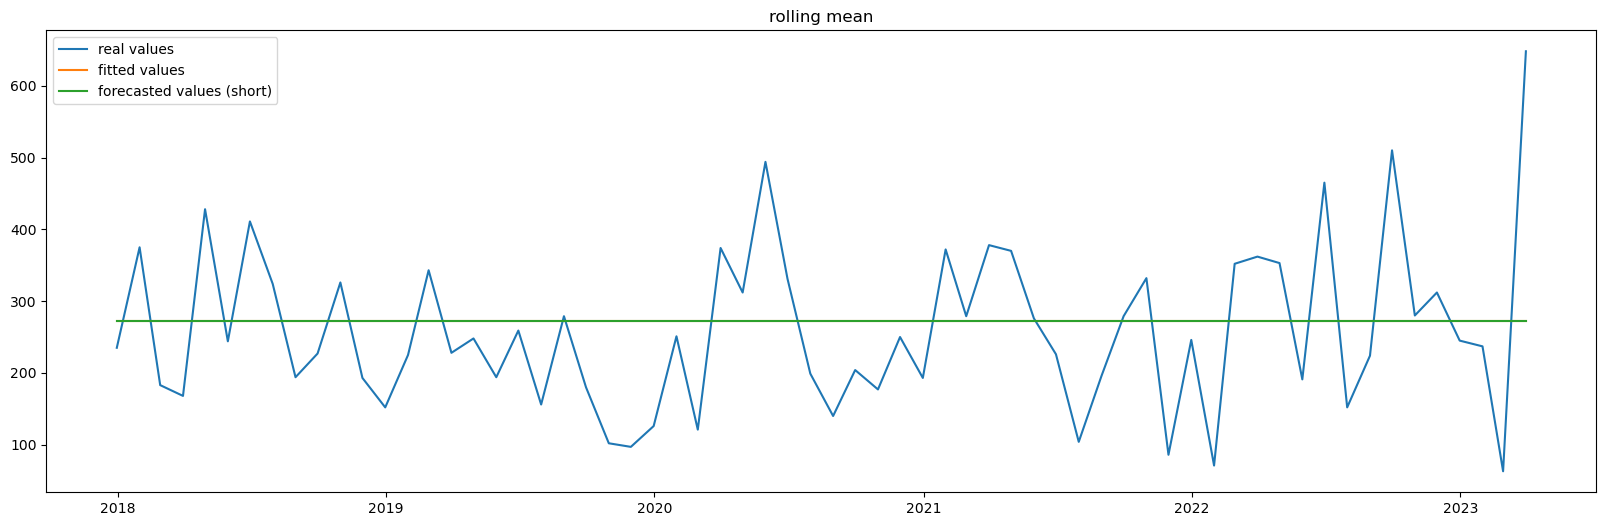

In [ ]:
window_size = 1  # was 5
fv = train_df.rolling(window=window_size)['best'].mean().values.tolist()
_train_df = train_df.copy()
for t in test_df.index:
    new_point = pd.DataFrame({'best': [fv[-1]]}, index=pd.DatetimeIndex([t], name='time'))
    _train_df = pd.concat([_train_df, new_point])
    fv = _train_df.rolling(window=window_size)['best'].mean()

#                    def plot_predictions(train_df, test_df, short_forecast, long_forecast=None, fitted=None, name=None, months_before=1):

losses['rolling_mean'] = plot_predictions(train_df, test_df, fv.iloc[-len(test_df):], None, fv, 'rolling mean')
print(losses)

rolling_mean             91.28
rolling_mean_monthly    100.31
dtype: float64


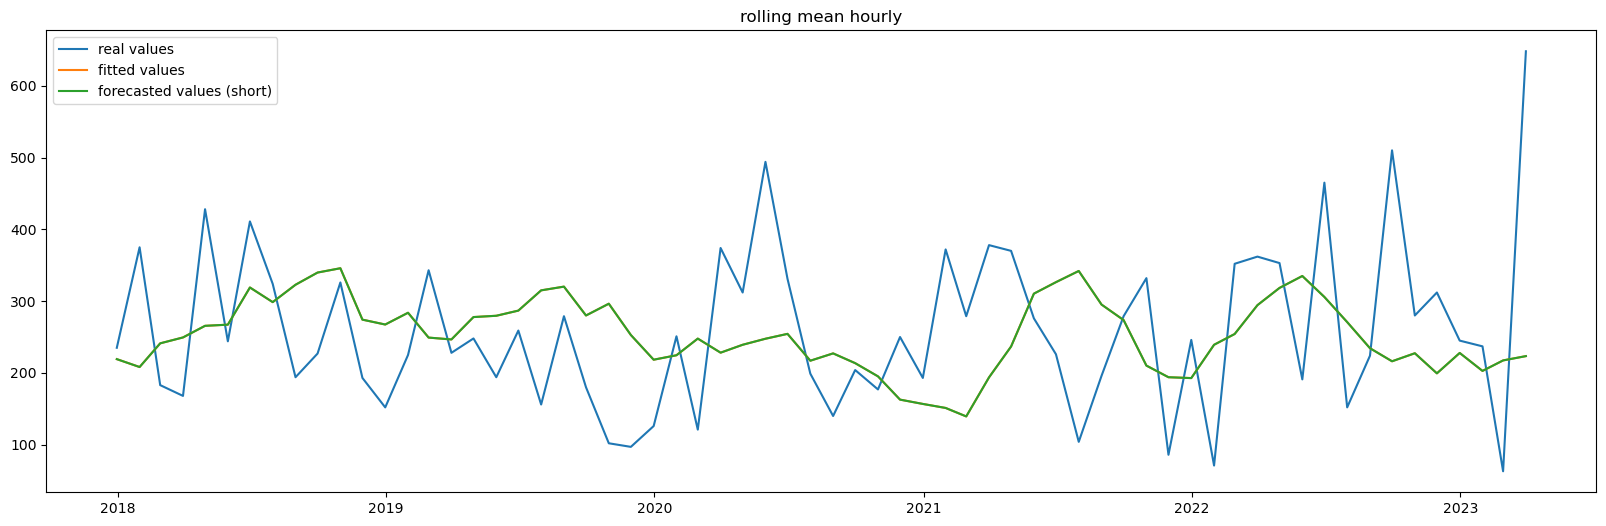

In [ ]:
# THIS CODE WILL NOT LEAK DATA
fv = pd.concat([train_df, test_df.assign(consumption=np.nan)]).sort_index()
fv = (
    fv.reset_index().set_index(['date_start', 'month'])
    .groupby("month").shift()["best"].reset_index(level=1)
    .rolling(window=5, min_periods=1)["best"]
    .mean()
    .sort_index()
)
losses['rolling_mean_monthly'] = plot_predictions(train_df, test_df, fv.iloc[-len(test_df):], None, fv, 'rolling mean hourly')
print(pd.Series(losses).sort_values())
# it seems to do better, it also seems like a more useful prediction
# what would happen if we'd need to extend the forecast N more days (e.g. 7 days)?

ValueError: Input contains NaN.

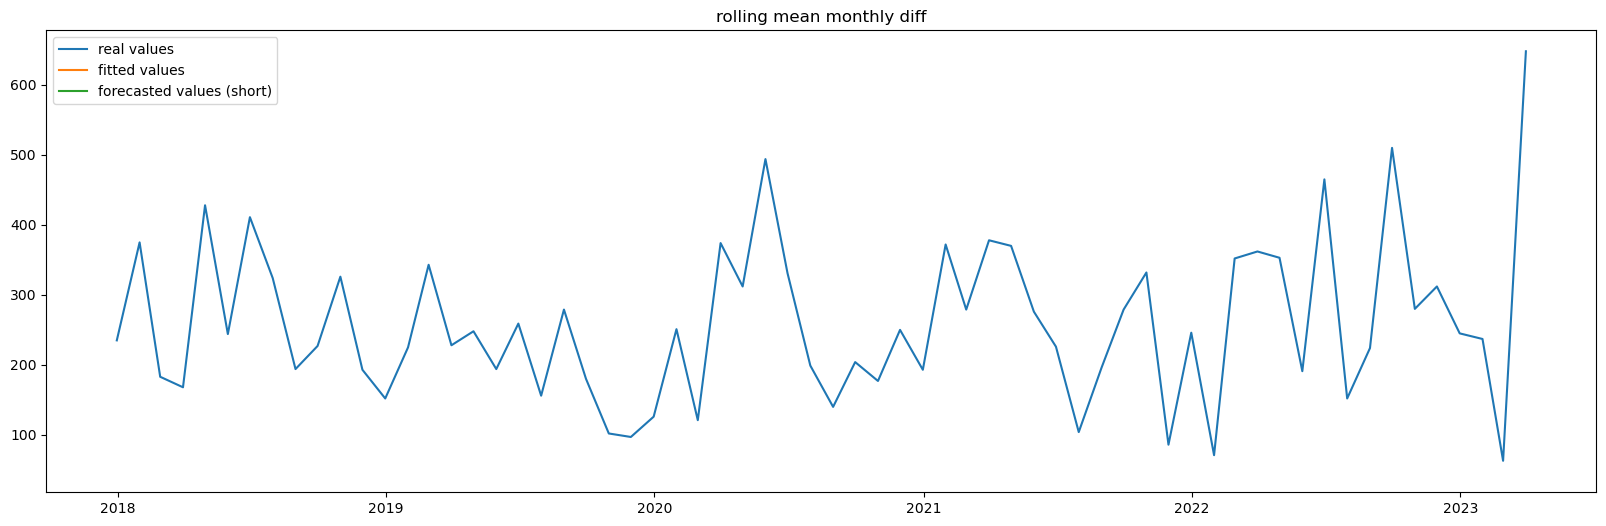

In [ ]:
import numpy as np
fv = pd.concat([train_df, test_df.assign(best=np.nan)]).sort_index()
fv = (
    fv.reset_index().set_index(['date_start', 'month'])
    .groupby("month").shift()["best"].reset_index().set_index(['date_start', 'month'])
    .groupby("month").diff()["best"].reset_index(level=1)
    .groupby('month').rolling(window=1, min_periods=1) #before was 5 (window)
    .mean()
    .reset_index(level=0)
    .sort_index()
)
#pre_diff_values = train_df.loc[train_df.index.isin(fv.iloc[:24].index), 'total_consumption']
# To revert the diff predictions to its original scale we just need to add the last known value to every prediction (the one before the diff)
# There are safer ways to do this, but this is the simplest one.
_train_df = train_df.copy()
_train_df.index = _train_df.index.shift(1, freq='M') # accepts month M
fv['best'] = fv['best'] + _train_df['best']
fv = fv['best']
losses['rolling_mean_monthly_diff'] = plot_predictions(train_df, test_df, fv.iloc[-len(test_df):], None, fv, 'rolling mean monthly diff', days_before=30)
print(pd.Series(losses).sort_values())
# Performance on test date is good, because the test day is very similar to the previous day.
# However if we were to evaluate on many days I suspect performance wouldn't be great

### ARIMA

In [ ]:
from sktime.forecasting.arima import ARIMA


arima = ARIMA(order=(1, 0, 0))

_train_df = train_df['total_consumption'].copy()
arima = arima.fit(_train_df)
arima.summary()

ModuleNotFoundError: No module named 'sktime'